#                                                **River Flow Forecasting**

A time series streamflow data is analyzed to forecast river flow and characterize the hydrological regime of the Yakima Gap-to-Gap reach of Yakima River, Washington. The methods applied are:

Part I - Clean and Transform Data
+ Load water resources data from USGS observation stations 
+ Clean data (handle missing values, duplicates, outliers) 
+ Transform data into time series format
+ Visualize time series to inspect exclude outliers or made some other pre-processing

Part II - Forcast Flow with Autoregressive Integrated Moving Average (ARIMA)model
+ Explore time series to understand trend and seasonal components
+ Apply visual and statistical tests to check if the data is stationary. ARIMA model assumed that data is stationary.
+ Fit and validate ARIMA model
+ Tune up hyperparameter to optimize model performance

Part III - Forcast Flow with Long Short-Term Memory (LSTM) model
+ Prepare LSTM data 
+ Train LSTM network
+ Tune up hyperparameter to optimize model performance

To make the codes run smoothly, three separate notebooks are created for each method. This specific notebook presents the data cleaning and transformation component. 

Note: River discharge is the volume of water passing a point in a given time (cubic feet per second), where as river flow is the rate of water flow (feet per second). Since the data is taken for a given section of a river, cross-section is constant. Therefore, discharge and flow have the same meaning and are used interchangeably. 

## Data Source (USGS Water Resources Record)
Water Resources data for the Yakima River near the Gap-to-Gap reach is available from two USGS gage stations.
+ Yakima River above Ahtanum Creek ([Station 12500450](https://maps.waterdata.usgs.gov/mapper/index.html)) at Union Gap, WA
+ Ahtanum Creek ([station 12502500)](https://maps.waterdata.usgs.gov/mapper/index.html) at Union Gap, WA

Daily flow data for [12500450](https://waterdata.usgs.gov/wa/nwis/dv?referred_module=sw&search_site_no=12500450&search_site_no_match_type=exact&site_tp_cd=OC&site_tp_cd=OC-CO&site_tp_cd=ES&site_tp_cd=LK&site_tp_cd=ST&site_tp_cd=ST-CA&site_tp_cd=ST-DCH&site_tp_cd=ST-TS&group_key=NONE&sitefile_output_format=html_table&column_name=agency_cd&column_name=site_no&column_name=station_nm&range_selection=date_range&begin_date=1950-03-31&end_date=2019-03-17&format=rdb&date_format=YYYY-MM-DD&rdb_compression=value&list_of_search_criteria=search_site_no%2Csite_tp_cd%2Crealtime_parameter_selection) and [12502500](https://waterdata.usgs.gov/wa/nwis/dv?referred_module=sw&search_site_no=12502500&search_site_no_match_type=exact&site_tp_cd=OC&site_tp_cd=OC-CO&site_tp_cd=ES&site_tp_cd=LK&site_tp_cd=ST&site_tp_cd=ST-CA&site_tp_cd=ST-DCH&site_tp_cd=ST-TS&group_key=NONE&sitefile_output_format=html_table&column_name=agency_cd&column_name=site_no&column_name=station_nm&period=365&range_selection=date_range&begin_date=2018-03-18&end_date=2019-03-17&format=rdb&date_format=YYYY-MM-DD&rdb_compression=value&list_of_search_criteria=search_site_no%2Csite_tp_cd%2Crealtime_parameter_selection) stations for a period of 1960 through 2019 is loaded from USGS real time data source. 

+ Data dictionary for site 12500450
            TS    parameter  statistic     Description
        149964       00010     00001     Temperature, water, degrees Celsius (Maximum)
        149965       00010     00002     Temperature, water, degrees Celsius (Minimum)
        149966       00010     00003     Temperature, water, degrees Celsius (Mean)
        149967       00060     00003     Discharge, cubic feet per second (Mean)
        149968       00065     00003     Gage height, feet (Mean)
        
+ Data dictionary for site 12502500
          TS       parameter  statistic Description
        149973       00060     00003     Discharge, cubic feet per second (Mean)
        149974       00065     00003     Gage height, feet (Mean)

## Daily Discharge Record at Yakima River above Ahtanum Creek station (12500450)

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from datetime import datetime
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Load data from Yakima River above Ahtanum Creek station (12500450) URL
pd.options.display.max_columns = 50 
yakima_450 = pd.read_csv("https://waterdata.usgs.gov/wa/nwis/dv?referred_module=sw&search_site_no=12500450&search_site_no_match_type=exact&site_tp_cd=OC&site_tp_cd=OC-CO&site_tp_cd=ES&site_tp_cd=LK&site_tp_cd=ST&site_tp_cd=ST-CA&site_tp_cd=ST-DCH&site_tp_cd=ST-TS&group_key=NONE&sitefile_output_format=html_table&column_name=agency_cd&column_name=site_no&column_name=station_nm&range_selection=date_range&begin_date=1950-03-31&end_date=2019-03-17&format=rdb&date_format=YYYY-MM-DD&rdb_compression=value&list_of_search_criteria=search_site_no%2Csite_tp_cd%2Crealtime_parameter_selection.csv", sep='\t', header = 33)
print(yakima_450.shape)# display number of rows and columns in tuples (rows, columns)
yakima_450.head() # display the top five rows 

(19162, 13)


,agency_cd,site_no,datetime,149964_00010_00001,149964_00010_00001_cd,149965_00010_00002,149965_00010_00002_cd,149966_00010_00003,149966_00010_00003_cd,149967_00060_00003,149967_00060_00003_cd,149968_00065_00003,149968_00065_00003_cd
0,5s,15s,20d,14n,10s,14n,10s,14n,10s,14n,10s,14n,10s
1,USGS,12500450,1966-10-01,NaN,NaN,NaN,NaN,NaN,NaN,1720,A,NaN,NaN
2,USGS,12500450,1966-10-02,NaN,NaN,NaN,NaN,NaN,NaN,1770,A,NaN,NaN
3,USGS,12500450,1966-10-03,NaN,NaN,NaN,NaN,NaN,NaN,1810,A,NaN,NaN
4,USGS,12500450,1966-10-04,NaN,NaN,NaN,NaN,NaN,NaN,1790,A,NaN,NaN


## Clean Data

+ Data set contains daily records of temperature (max, min, and mean), discharge (mean), and gage height (mean). 
+ The data has two header columns. The first header column is the name of features in numerical codes and should be renamed to make it easy to understand. The second header is a piece of supplemental information that is not needed for this analysis. 
+ **"_cd"** in column names is a description of data-qualification code which indicates
     + **A** - Approved for publication -- processing and review completed
     + **P** - Provisional data subject to revision
     + **e** - Value has been estimated
+ Missing values need to be removed or replaced

### Rename Columns

In [17]:
# Display columns
yakima_450.columns

Index(['agency_cd', 'site_no', 'datetime', '149964_00010_00001',
       '149964_00010_00001_cd', '149965_00010_00002', '149965_00010_00002_cd',
       '149966_00010_00003', '149966_00010_00003_cd', '149967_00060_00003',
       '149967_00060_00003_cd', '149968_00065_00003', '149968_00065_00003_cd'],
      dtype='object')

In [29]:
# Rename columns
cols_names = {'datetime': 'date', '149964_00010_00001': 'max_t',
       '149964_00010_00001_cd': 'max_t_cd', '149965_00010_00002': 'min_t', '149965_00010_00002_cd': 'min_t_cd',
       '149966_00010_00003': 'mean_t', '149966_00010_00003_cd': 'mean_t_cd', '149967_00060_00003': 'mean_q_cfs',
       '149967_00060_00003_cd' : 'mean_q_cfs_cd', '149968_00065_00003': 'mean_h_ft', 
              '149968_00065_00003_cd': 'mean_h_ft_cd'}

yakima_450 = yakima_450.rename(columns = cols_names)
yakima_450.head()

,agency_cd,site_no,date,max_t,max_t_cd,min_t,min_t_cd,mean_t,mean_t_cd,mean_q_cfs,mean_q_cfs_cd,mean_h_ft,mean_h_ft_cd
0,5s,15s,20d,14n,10s,14n,10s,14n,10s,14n,10s,14n,10s
1,USGS,12500450,1966-10-01,NaN,NaN,NaN,NaN,NaN,NaN,1720,A,NaN,NaN
2,USGS,12500450,1966-10-02,NaN,NaN,NaN,NaN,NaN,NaN,1770,A,NaN,NaN
3,USGS,12500450,1966-10-03,NaN,NaN,NaN,NaN,NaN,NaN,1810,A,NaN,NaN
4,USGS,12500450,1966-10-04,NaN,NaN,NaN,NaN,NaN,NaN,1790,A,NaN,NaN


In [30]:
# Remove the second header at index [0]
yakima_450 = yakima_450.copy()
yakima_450 = yakima_450.drop(yakima_450.index[0]).reset_index()

### Explore Data Qualification Code

In [32]:
# Explore the QA-cd for discharge
yakima_450['mean_q_cfs_cd'].value_counts(normalize = True)*100

A      95.616095
A:e     3.705443
P       0.636710
P:e     0.041751
Name: mean_q_cfs_cd, dtype: float64

It turns out that over 99% (95.6% A & 3.7% A:e) of data quality is approved. We need to investigate data points with the provisional category (P and P:e).

In [63]:
# Explore provisional data
yakima_450 = yakima_450.copy()
print ('First five rows' + '\n' + '-'*32)
print(yakima_450[(yakima_450['mean_q_cfs_cd'] == 'P:e') | (yakima_450['mean_q_cfs_cd'] == 'P')]['date'].head())
print('\n' + 'Last five rows' + '\n' + '-'*32 )
print(yakima_450[(yakima_450['mean_q_cfs_cd'] == 'P:e') | (yakima_450['mean_q_cfs_cd'] == 'P')]['date'].tail())

First five rows
--------------------------------
19031    2018-11-08
19032    2018-11-09
19033    2018-11-10
19034    2018-11-11
19035    2018-11-12
Name: date, dtype: object

Last five rows
--------------------------------
19156    2019-03-13
19157    2019-03-14
19158    2019-03-15
19159    2019-03-16
19160    2019-03-17
Name: date, dtype: object


It looks that the provisional data points are recorded/estimated in 2018-2019, which are likely under the data quality review process. These data points need to be excluded from this analysis.  

### Separate Flow Data
This creates a dataset of mean discharge (q_mean_cfs) and date (date) columns with rows where data qualities are approved (A, A:e).

In [71]:
approved_data_450 = yakima_450[(yakima_450['mean_q_cfs_cd'] == 'A:e') | (yakima_450['mean_q_cfs_cd'] == 'A')].head()
yakima_450_discharge = yakima_450[['date', 'mean_q_cfs']]
yakima_450_discharge.head()

,date,mean_q_cfs
0,1966-10-01,1720
1,1966-10-02,1770
2,1966-10-03,1810
3,1966-10-04,1790
4,1966-10-05,1720


In [73]:
## Desplay data statistics
yakima_450_discharge.describe()

,date,mean_q_cfs
count,19161,19161
unique,19161,1260
top,2010-06-30,3400
freq,1,83


## Handle Missing Values

In [76]:
# Explore missing values
yakima_450_discharge.isnull().sum()

date          0
mean_q_cfs    0
dtype: int64

It seems that there is no missing discharge values. However, missing values can be represented with '0.' This need to be inspected

In [78]:
print(yakima_450_discharge['mean_q_cfs'].min())
yakima_450_discharge[yakima_450_discharge['mean_q_cfs']==0]

1000


,date,mean_q_cfs


The minimum discharge record is 1000 cfs and there is no row containing a value of 0. This confirms that the data has no missing values.

### Check Duplicates

In [87]:
# Check duplicates by displaying unique values
yakima_450_discharge['date'].describe()

count          19161
unique         19161
top       2010-06-30
freq               1
Name: date, dtype: object

Since the total data point count is equal to the number of unique dates, there is no duplicate in the time series.

### Transform Data to Time Series

In [7]:
# Check data type
yakima_450_discharge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19161 entries, 0 to 19160
Data columns (total 2 columns):
date          19161 non-null object
mean_q_cfs    19161 non-null object
dtypes: object(2)
memory usage: 449.1+ KB


In [88]:
# Convert discharge data to numeric
yakima_450_discharge = yakima_450_discharge.copy()
yakima_450_discharge['mean_q_cfs'] = yakima_450_discharge['mean_q_cfs'].apply(pd.to_numeric, errors = 'coerce')
yakima_450_discharge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19161 entries, 0 to 19160
Data columns (total 2 columns):
date          19161 non-null object
mean_q_cfs    19161 non-null int64
dtypes: int64(1), object(1)
memory usage: 299.5+ KB


The date object need to be converted into datetime format and set as dataframe index.

In [90]:
# Convert date into datetime and reset index
yakima_450_discharge = yakima_450_discharge.copy()
yakima_450_discharge['date'] = pd.to_datetime(yakima_450_discharge['date'])
yakima_450_discharge = yakima_450_discharge.set_index(['date'])
yakima_450_discharge.index

DatetimeIndex(['1966-10-01', '1966-10-02', '1966-10-03', '1966-10-04',
               '1966-10-05', '1966-10-06', '1966-10-07', '1966-10-08',
               '1966-10-09', '1966-10-10',
               ...
               '2019-03-08', '2019-03-09', '2019-03-10', '2019-03-11',
               '2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15',
               '2019-03-16', '2019-03-17'],
              dtype='datetime64[ns]', name='date', length=19161, freq=None)

In [105]:
# Export cleaned data into local disk for Phase II and III
yakima_450_discharge.to_csv('yakima_450_discharge.csv', sep = ',')

### Visualize Flow Time Series

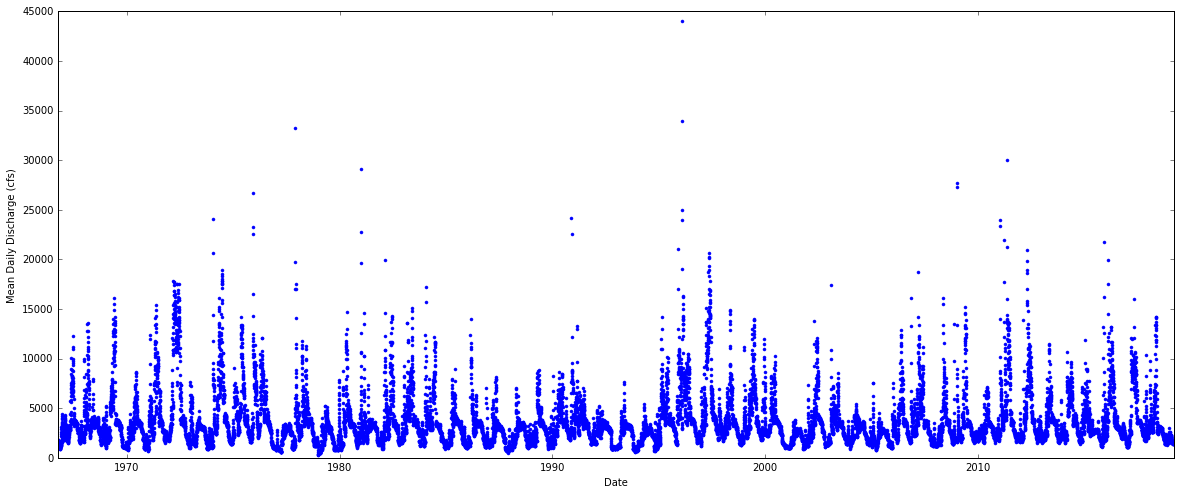

In [97]:
# Plot mean daily discharge
plt.style.use('classic')
%matplotlib inline
yakima_ = yakima_450_discharge.copy()
fig = plt.figure(figsize=(20,8))
plt.plot(yakima_.mean_q_cfs, marker='.', linestyle='none')
plt.ylabel('Mean Daily Discharge (cfs)')
plt.xlabel('Date')
plt.show()

# Export fig
fig.savefig('yakima_450_discharge.png', dpi=500)

## Daily Flow Record at Ahtanum Creek station (12502500)

In [179]:
# Read data from Ahtanum Creek station (12502500)
pd.options.display.max_columns = 50
ahtanum_500 = pd.read_csv('https://waterdata.usgs.gov/wa/nwis/dv?referred_module=sw&search_site_no=12502500&search_site_no_match_type=exact&site_tp_cd=OC&site_tp_cd=OC-CO&site_tp_cd=ES&site_tp_cd=LK&site_tp_cd=ST&site_tp_cd=ST-CA&site_tp_cd=ST-DCH&site_tp_cd=ST-TS&group_key=NONE&sitefile_output_format=html_table&column_name=agency_cd&column_name=site_no&column_name=station_nm&range_selection=date_range&begin_date=1950-03-31&end_date=2019-03-17&format=rdb&date_format=YYYY-MM-DD&rdb_compression=value&list_of_search_criteria=search_site_no%2Csite_tp_cd%2Crealtime_parameter_selection', sep='\t', header = 30)
print(ahtanum_500.shape) 
ahtanum_500.head () 

(24763, 7)


,agency_cd,site_no,datetime,149973_00060_00003,149973_00060_00003_cd,149974_00065_00003,149974_00065_00003_cd
0,5s,15s,20d,14n,10s,14n,10s
1,USGS,12502500,1951-06-01,247,A,NaN,NaN
2,USGS,12502500,1951-06-02,234,A,NaN,NaN
3,USGS,12502500,1951-06-03,226,A,NaN,NaN
4,USGS,12502500,1951-06-04,270,A,NaN,NaN


## Clean Data

+ Data set contains daily records of discharge (mean) and gage height (mean). 
+ The dataframe has two header columns. The first header column is the name of features in numerical codes and should be renamed to make it easy to understand. The second header is a piece of supplemental information that is not needed for this analysis. 
+ The first row contains information not relevant for this analysis
+ **"_cd"** in column names is a description of data-qualification code which indicates
     + **A** - Approved for publication -- processing and review completed
     + **P** - Provisional data subject to revision
     + **e** - Value has been estimated
+ Missing values need to be removed or replaced

### Rename Columns

In [180]:
ahtanum_500.columns

Index(['agency_cd', 'site_no', 'datetime', '149973_00060_00003',
       '149973_00060_00003_cd', '149974_00065_00003', '149974_00065_00003_cd'],
      dtype='object')

In [181]:
# Rename columns
cols_name2 = {'datetime': 'date', '149973_00060_00003': 'mean_q_cfs', '149973_00060_00003_cd' : 'mean_q_cfs_cd', 
             '149974_00065_00003': 'mean_h_ft', '149974_00065_00003_cd': 'mean_h_ft_cd'}

ahtanum_500 = ahtanum_500.rename(columns = cols_name2)
ahtanum_500.head()

,agency_cd,site_no,date,mean_q_cfs,mean_q_cfs_cd,mean_h_ft,mean_h_ft_cd
0,5s,15s,20d,14n,10s,14n,10s
1,USGS,12502500,1951-06-01,247,A,NaN,NaN
2,USGS,12502500,1951-06-02,234,A,NaN,NaN
3,USGS,12502500,1951-06-03,226,A,NaN,NaN
4,USGS,12502500,1951-06-04,270,A,NaN,NaN


In [183]:
# Remove the second header at index [0]
ahtanum_500 = ahtanum_500.copy()
ahtanum_500 = ahtanum_500.drop(ahtanum_500.index[0]).reset_index()

### Explore Data Qualification Code

In [184]:
# Explore the QA-cd for discharge
ahtanum_500['mean_q_cfs_cd'].value_counts(normalize = True)*100

A      98.487524
A:e     0.765295
P       0.747181
Name: mean_q_cfs_cd, dtype: float64

Over 99% of discharge data quality is approved. 

In [185]:
# Explore provisional data
ahtanum_500 = ahtanum_500.copy()
print ('First five rows' + '\n' + '-'*32)
print(ahtanum_500[(ahtanum_500['mean_q_cfs_cd'] == 'P:e') | 
                     (ahtanum_500['mean_q_cfs_cd'] == 'P')]['date'].head())
print('\n' + 'Last five rows' + '\n' + '-'*32 )
print(ahtanum_500[(ahtanum_500['mean_q_cfs_cd'] == 'P:e') | 
                  (ahtanum_500['mean_q_cfs_cd'] == 'P')]['date'].tail())

First five rows
--------------------------------
24597    2018-10-04
24598    2018-10-05
24599    2018-10-06
24600    2018-10-07
24601    2018-10-08
Name: date, dtype: object

Last five rows
--------------------------------
24757    2019-03-13
24758    2019-03-14
24759    2019-03-15
24760    2019-03-16
24761    2019-03-17
Name: date, dtype: object


The provisional data are recorded/estimateed in 2018-2019, which are likely under QA process. These data points need to be excluded.  

### Separate Discharge Data

This creates a dataset of mean discharge (q_mean_cfs) and date (date) columns with rows where data qualities are approved (A, A:e).

In [186]:
ahtanum_500 = ahtanum_500[(ahtanum_500['mean_q_cfs_cd'] == 'A:e') |
                                (ahtanum_500['mean_q_cfs_cd'] == 'A')]
ahtanum_500 = ahtanum_500[['date', 'mean_q_cfs']]
ahtanum_500.head()

,date,mean_q_cfs
0,1951-06-01,247
1,1951-06-02,234
2,1951-06-03,226
3,1951-06-04,270
4,1951-06-05,335


### Handle Missing Values

In [187]:
# Explore missing values
ahtanum_500.isnull().sum()

date          0
mean_q_cfs    0
dtype: int64

It seems that there is no missing values with nan inspectation. However, missing values can be represented with '0.' This need to be inspected.

In [188]:
print(ahtanum_500['mean_q_cfs'].min())
ahtanum_500[ahtanum_500['mean_q_cfs']==0]

10.0


,date,mean_q_cfs


This confirms that the dataframe has no missing values.

### Check Duplicates

In [192]:
# Check duplicates by displaying date unique values

ahtanum_500['date'].describe()

count          21918
unique         21918
top       2010-06-30
freq               1
Name: date, dtype: object

Since the total data point count is equal to the number of unique date, there is no duplicate in the time series.

### Transform Data to Time Series

In [193]:
# Check data type
ahtanum_500.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21918 entries, 0 to 24596
Data columns (total 2 columns):
date          21918 non-null object
mean_q_cfs    21918 non-null object
dtypes: object(2)
memory usage: 513.7+ KB


In [194]:
# Convert discharge data to numeric
ahtanum_500 = ahtanum_500.copy()
ahtanum_500['mean_q_cfs'] = ahtanum_500['mean_q_cfs'].apply(pd.to_numeric, errors = 'coerce')
ahtanum_500.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21918 entries, 0 to 24596
Data columns (total 2 columns):
date          21918 non-null object
mean_q_cfs    21918 non-null float64
dtypes: float64(1), object(1)
memory usage: 513.7+ KB


In [195]:
# Convert date into datetime and reset index
ahtanum_500 = ahtanum_500.copy()
ahtanum_500['date'] = pd.to_datetime(ahtanum_500['date'])
ahtanum_500 = ahtanum_500.set_index(['date'])
ahtanum_500.index

DatetimeIndex(['1951-06-01', '1951-06-02', '1951-06-03', '1951-06-04',
               '1951-06-05', '1951-06-06', '1951-06-07', '1951-06-08',
               '1951-06-09', '1951-06-10',
               ...
               '2018-09-24', '2018-09-25', '2018-09-26', '2018-09-27',
               '2018-09-28', '2018-09-29', '2018-09-30', '2018-10-01',
               '2018-10-02', '2018-10-03'],
              dtype='datetime64[ns]', name='date', length=21918, freq=None)

In [196]:
# Export cleaned data into local disk for Phase II and III
ahtanum_500.to_csv('ahtanum_500.csv', sep = ',')

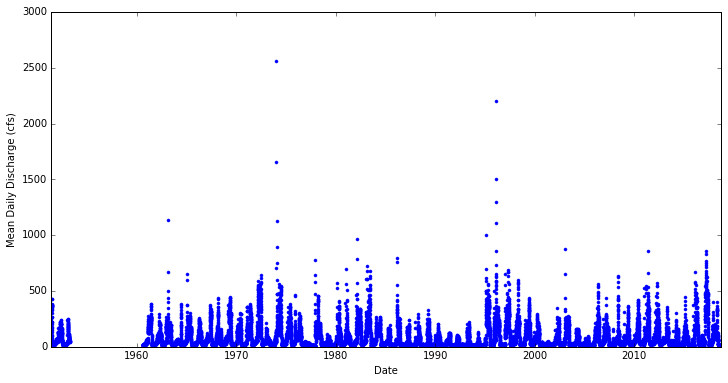

In [197]:
# Plot flow
plt.style.use('classic')
%matplotlib inline
ahtanum_500 = ahtanum_500.copy()
fig = plt.figure(figsize=(12,6))
plt.plot(ahtanum_500, marker='.', linestyle='none')
plt.ylabel('Mean Daily Discharge (cfs)')
plt.xlabel('Date')
plt.show()

# Export fig
fig.savefig('ahtanum_500.png', dpi=500)